Packages

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns

Data Load

In [2]:
cars_file = 'https://gist.githubusercontent.com/noamross/e5d3e859aa0c794be10b/raw/b999fb4425b54c63cab088c0ce2c0d6ce961a563/cars.csv'
cars = pd.read_csv(cars_file)
cars.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


visualise the model

<Axes: xlabel='wt', ylabel='mpg'>

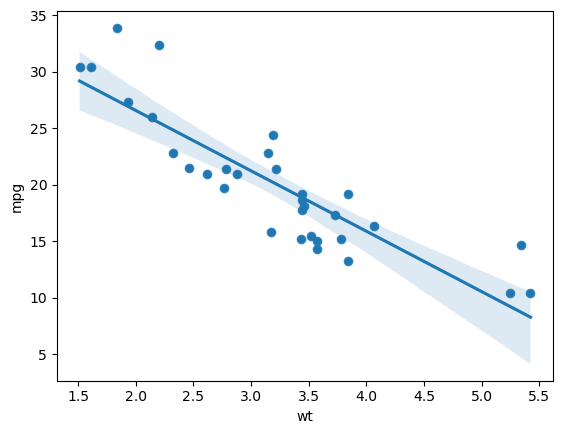

In [3]:
sns.scatterplot(x='wt', y='mpg', data=cars)
sns.regplot(x='wt', y='mpg', data=cars)

convert data to tensor

In [4]:
X_list = cars.wt.values
X_np = np.array(X_list, dtype=np.float32).reshape(-1,1)
y_list = cars.mpg.values
y_np = np.array(y_list, dtype=np.float32).reshape(-1,1)
X = torch.from_numpy(X_np)
y_true = torch.from_numpy(y_np)

Dataset and Dataloader

In [5]:
from torch.utils.data import Dataset, DataLoader 


In [8]:
class LinearRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
train_loader = DataLoader(dataset = LinearRegressionDataset(X=X_np,y= y_np), batch_size=2)

Model

In [5]:
class LinearRegressionTorch(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

In [6]:
input_dim=1
output_dim=1
model=LinearRegressionTorch(input_size=input_dim, output_size=output_dim)
model.train()
loss_fn=nn.MSELoss()
LR=0.02

Optimizer

In [7]:
optimizer=torch.optim.SGD(model.parameters(), lr=LR)

1. Train without skorch

In [13]:
losses, slope, bias = [], [], []
NUM_EPOCHS = 1000
BATCH_SIZE = 2
for epoch in range (NUM_EPOCHS):
    for i,(X,y) in enumerate(train_loader):
        
        # set gradients to zero
        optimizer.zero_grad()
        # forward pass
        y_pred=model(X)
        # calculate loss
        loss=loss_fn(y_pred,y)
        
        loss.backward()
        # update parameters
        optimizer.step()
    
    slope.append(model.linear.weight.item())
    bias.append(model.linear.bias.item())
    losses.append(loss.item())
     # Debugging: print loss and parameter values every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        print(f"Slope: {model.linear.weight.item()}, Bias: {model.linear.bias.item()}")
        for param in model.parameters():
            print(f"Gradient for parameter: {param.grad}")

Epoch 0, Loss: 35.88936996459961
Slope: 5.066379547119141, Bias: 3.325651168823242
Gradient for parameter: tensor([[21.1281]])
Gradient for parameter: tensor([5.3188])
Epoch 100, Loss: 1.5690571069717407
Slope: -5.57387113571167, Bias: 36.233734130859375
Gradient for parameter: tensor([[5.2564]])
Gradient for parameter: tensor([1.3968])
Epoch 200, Loss: 1.4115431308746338
Slope: -5.720515727996826, Bias: 36.687278747558594
Gradient for parameter: tensor([[5.0377]])
Gradient for parameter: tensor([1.3428])
Epoch 300, Loss: 1.4094297885894775
Slope: -5.722537517547607, Bias: 36.69353103637695
Gradient for parameter: tensor([[5.0347]])
Gradient for parameter: tensor([1.3420])
Epoch 400, Loss: 1.409427285194397
Slope: -5.722538948059082, Bias: 36.69353485107422
Gradient for parameter: tensor([[5.0346]])
Gradient for parameter: tensor([1.3420])
Epoch 500, Loss: 1.409427285194397
Slope: -5.722538948059082, Bias: 36.69353485107422
Gradient for parameter: tensor([[5.0346]])
Gradient for parame

2.train with skorch

In [ ]:
!pip install skorch

In [8]:
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

In [12]:
net=NeuralNetRegressor(
    LinearRegressionTorch(input_size=input_dim, output_size=output_dim),
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)
net.set_params(train_split=False, verbose=0)

<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=LinearRegressionTorch(
    (linear): Linear(in_features=1, out_features=1, bias=True)
  ),
)

In [13]:
params = {
    'lr': [0.02, 0.05, 0.08],
    'max_epochs': [10, 200, 500],
}

In [14]:
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='r2', verbose=2)

gs.fit(X, y_true)
print(f"best score: {gs.best_score_:.3f}, best params: {gs.best_params_}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.2s
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.0s
[CV] END ............................lr=0.02, max_epochs=200; total time=   0.3s
[CV] END ............................lr=0.02, max_epochs=200; total time=   0.2s
[CV] END ............................lr=0.02, max_epochs=200; total time=   0.2s
[CV] END ............................lr=0.02, max_epochs=500; total time=   0.7s
[CV] END ............................lr=0.02, max_epochs=500; total time=   0.7s
[CV] END ............................lr=0.02, max_epochs=500; total time=   0.7s
[CV] END .............................lr=0.05, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.05, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.05, ma

c:\Users\prane\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1220: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)
c:\Users\prane\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [-2.61029951e+00 -4.19260343e-01  3.72182329e-01 -2.31534195e+00
  3.72934361e-01  5.87722083e-01 -4.40414159e+01 -2.88600398e+19
            -inf]
  warnings.warn(
c:\Users\prane\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1113: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


visualise model training

<Axes: >

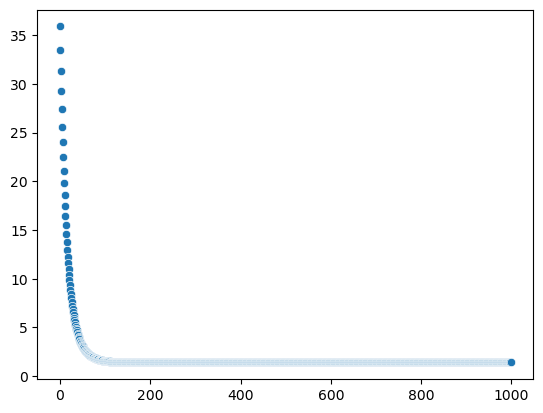

In [14]:
# sns.scatterplot(x=range(NUM_EPOCHS), y=losses)
sns.scatterplot(x=range(len(losses)), y=losses)

visualise the bias development

<Axes: >

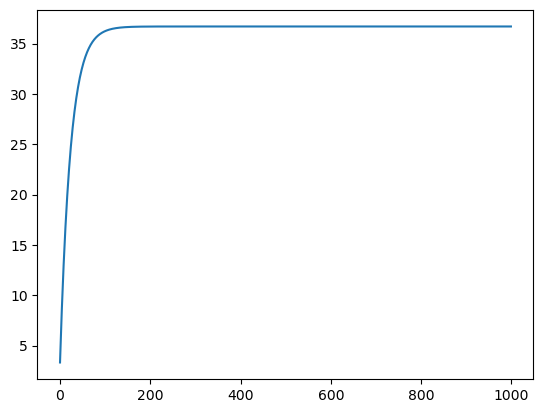

In [15]:
sns.lineplot(x=range(NUM_EPOCHS), y=bias)

visualise the slope development

<Axes: >

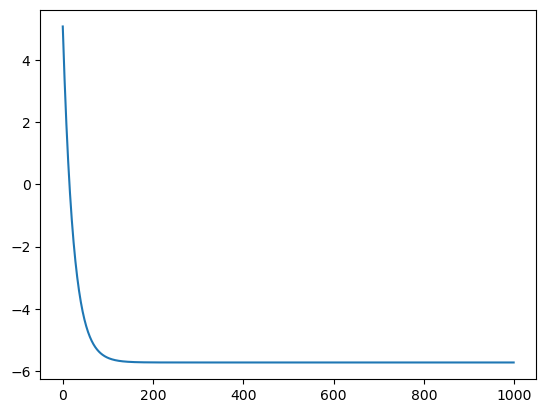

In [16]:
sns.lineplot(x=range(NUM_EPOCHS), y=slope)

Model Save

In [20]:
# model state dict
model.state_dict()

OrderedDict([('linear.weight', tensor([[-5.7225]])),
             ('linear.bias', tensor([36.6935]))])

In [22]:
from pathlib import Path
Path("artifacts").mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), 'artifacts/model_state_dict.pth')

Model Load

In [24]:
model_load = LinearRegressionTorch(input_size=input_dim, output_size=output_dim)
model_load.load_state_dict(torch.load('artifacts/model_state_dict.pth'))
model_load.state_dict()

OrderedDict([('linear.weight', tensor([[-5.7225]])),
             ('linear.bias', tensor([36.6935]))])

check the result

<Axes: >

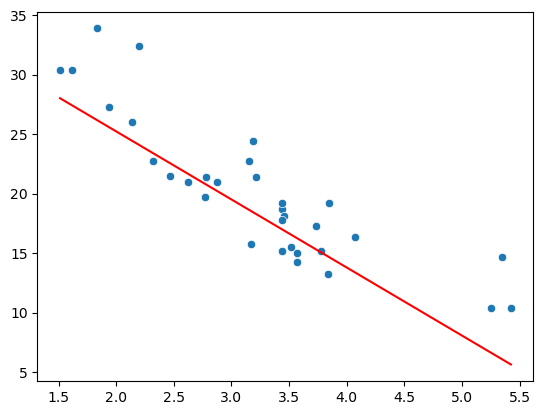

In [25]:
model_load.eval()
y_pred = [i[0] for i in model(torch.from_numpy(X_np)).data.numpy()]
y = [i[0] for i in y_true.data.numpy()]
sns.scatterplot(x=X_list, y=y)
sns.lineplot(x=X_list, y=y_pred, color='red')